## 1. Approach Overview

The problem can be formulated as a classical **Orienteering Problem (OP)**, which in turn can be expressed as a **Mixed Integer Linear Program (MILP)**.  
Since solving MILP requires commercial solvers such as **Gurobi** and can be computationally expensive for large instances, we adopt an **engineering-oriented heuristic approach** instead:

- **Greedy construction**: builds an initial solution by iteratively selecting the next goal.
- **2-opt local optimization**: improves the greedy path by eliminating edge crossings and reducing length.
- **Refill heuristic** (extended method): attempts to insert missed goals back into the path.

This provides a practical trade-off between runtime efficiency and solution quality.  
A brief mathematical model will be provided in the **Appendix**.


## 2. Implementation Details

Our solution consists of the following key components:

- **Data loading and preprocessing**  
  The algorithm reads instance results from CSV files (`log_greedy.csv`, `log_greedy2opt.csv`, `log_greedy2optRefill.csv`).  
  Each row contains `instance`, `goals_visited`, `goals_total`, `percent`, `length`, `valid`, and `runtime_s`.

- **Greedy construction**  
  Builds an initial feasible path by iteratively selecting the next best candidate goal (e.g., shortest distance or highest feasibility), subject to path length constraints.

- **2-opt local search**  
  Applies the classical 2-opt heuristic to the greedy solution.  
  Edges are swapped to reduce the total path length until no further improvement is possible within iteration limits.

- **Refill heuristic (extended method)**  
  After 2-opt optimization, missed goals are checked for reinsertion into the path if this can be done with limited additional cost.  
  This step aims to slightly improve the goal completion percentage without significantly increasing runtime.

- **Performance logging**  
  For each instance, we record the path length, percentage of goals visited, validity, and runtime.  
  These metrics are later aggregated to compare methods.

This modular design makes it straightforward to evaluate and visualize the performance differences among the three approaches.


## 3. Performance Analysis & Results Summary

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

df_greedy = pd.read_csv("log_greedy.csv")
df_greedy2opt = pd.read_csv("log_greedy2opt.csv")
df_greedy2optRefill = pd.read_csv("log_greedy2optRefill.csv")

print(df_greedy.head())
print(df_greedy2opt.head())
print(df_greedy2optRefill.head())


       instance  goals_visited  goals_total  percent   length  valid  runtime_s
0  instance_001              4            8     50.0  1447.59   True        0.0
1  instance_002              4            8     50.0  1900.83   True        0.0
2  instance_003              4            5     80.0  1593.24   True        0.0
3  instance_004              4            8     50.0  1657.66   True        0.0
4  instance_005              3            4     75.0  1148.23   True        0.0
       instance  goals_visited  goals_total  percent   length  valid  runtime_s
0  instance_001              4            8     50.0  1447.59   True     0.0071
1  instance_002              4            8     50.0  1900.83   True     0.0010
2  instance_003              4            5     80.0  1593.24   True     0.0010
3  instance_004              4            8     50.0  1657.66   True     0.0000
4  instance_005              3            4     75.0  1148.23   True     0.0000
       instance  goals_visited  goals_to

### a） First, compare Greedy Only with Greedy+2opt

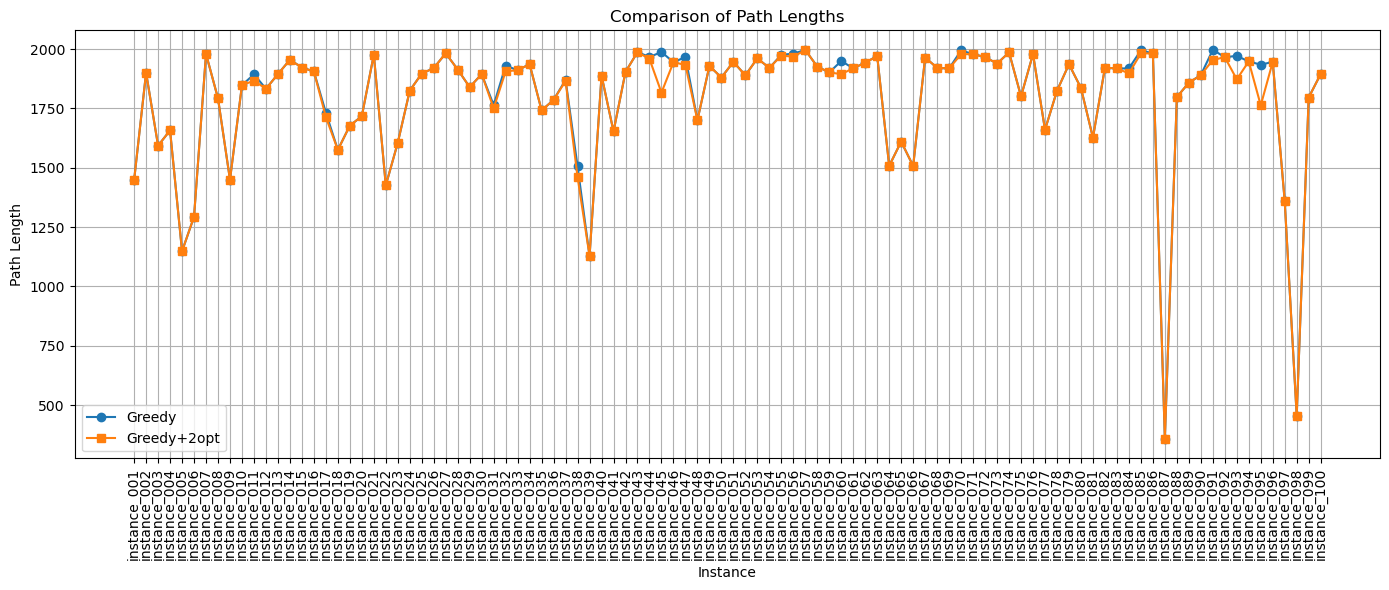

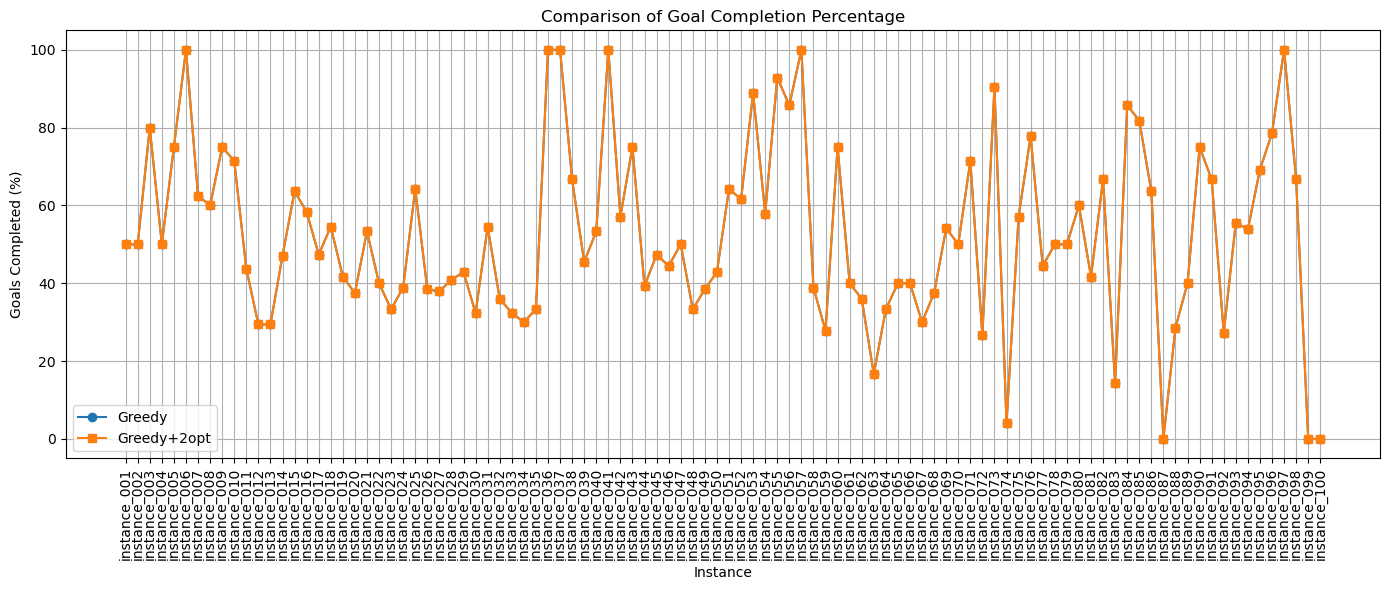

In [ ]:
# read data
plt.figure(figsize=(14,6))
plt.plot(df_greedy["instance"], df_greedy["length"], label="Greedy", marker="o")
plt.plot(df_greedy2opt["instance"], df_greedy2opt["length"], label="Greedy+2opt", marker="s")


plt.xticks(rotation=90)
plt.xlabel("Instance")
plt.ylabel("Path Length")
plt.title("Comparison of Path Lengths")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- figure: Goal Percent ---
plt.figure(figsize=(14,6))
plt.plot(df_greedy["instance"], df_greedy["percent"], label="Greedy", marker="o")
plt.plot(df_greedy2opt["instance"], df_greedy2opt["percent"], label="Greedy+2opt", marker="s")


plt.xticks(rotation=90)
plt.xlabel("Instance")
plt.ylabel("Goals Completed (%)")
plt.title("Comparison of Goal Completion Percentage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### b) It can be seen several paths has been reduced after applying 2-opt. So we then can try to insert point again for these paths. The goals percentages are the same for these 2 methods because we have not tried to add points yet. However, we can already see some paths have high goal percentage, which means the greedy method is good enough.

### c) Next, try to refill the remaining goals again to see if we can add more goals to those reduced paths.

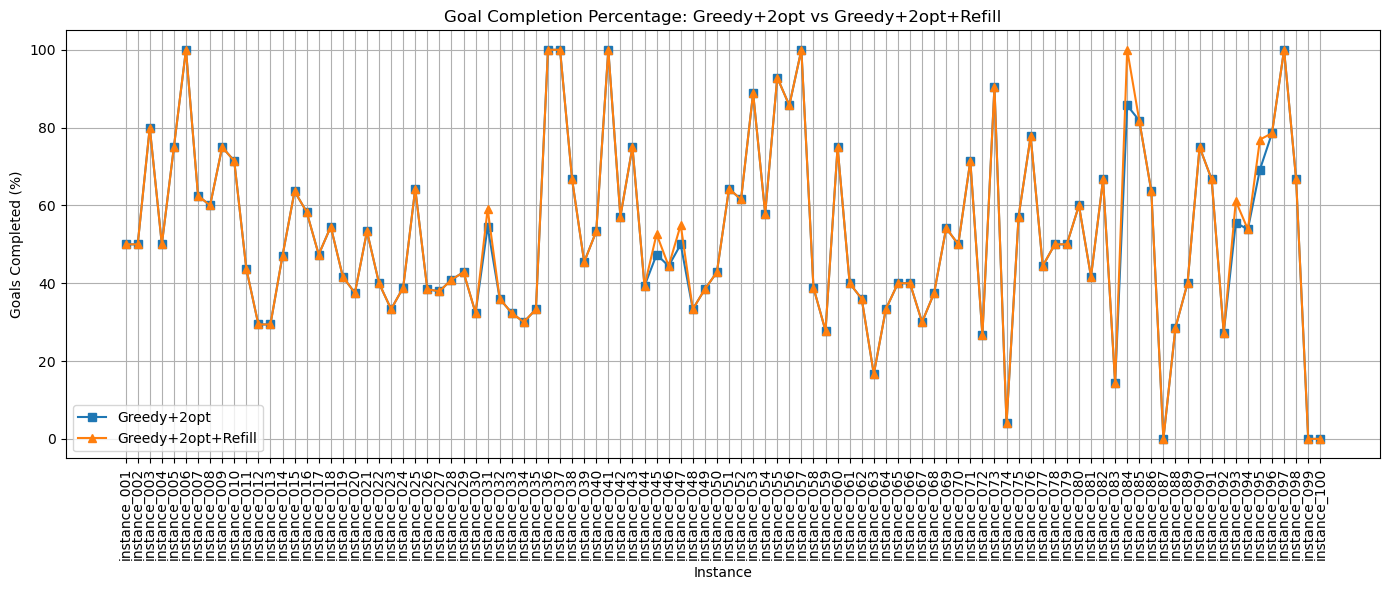

In [ ]:
# --- figure: Goal Percent comparison ---
plt.figure(figsize=(14,6))
plt.plot(df_greedy2opt["instance"], df_greedy2opt["percent"], label="Greedy+2opt", marker="s")
plt.plot(df_greedy2optRefill["instance"], df_greedy2optRefill["percent"], label="Greedy+2opt+Refill", marker="^")

plt.xticks(rotation=90)
plt.xlabel("Instance")
plt.ylabel("Goals Completed (%)")
plt.title("Goal Completion Percentage: Greedy+2opt vs Greedy+2opt+Refill")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###  Out of those 14 reduced paths, 5 paths can add 1 more goal.

In [ ]:
# Calculate goal percentage AND runtime 
stats = pd.DataFrame({
    "Method": ["Greedy", "Greedy+2opt", "Greedy+2opt+Refill"],
    "Average Goal %": [
        df_greedy["percent"].mean(),
        df_greedy2opt["percent"].mean(),
        df_greedy2optRefill["percent"].mean()
    ],
    "Total Runtime (s)": [
        df_greedy["runtime_s"].sum(),
        df_greedy2opt["runtime_s"].sum(),
        df_greedy2optRefill["runtime_s"].sum()
    ]
})

print(stats)

               Method  Average Goal %  Total Runtime (s)
0              Greedy       52.461623             0.6969
1         Greedy+2opt       52.461623             0.7332
2  Greedy+2opt+Refill       52.885044             0.7665


## Appendix: Simplified MILP Formulation of the Orienteering Problem

The Orienteering Problem (OP) can be expressed as a Mixed Integer Linear Program (MILP).

**Decision variables**
- $x_{ij} = 1$ if edge $(i,j)$ is used, 0 otherwise.  
- $y_i = 1$ if node $i$ is visited, 0 otherwise.  

**Objective (lexicographic)**
 - Maximize the number of visited goals.  
 

**Main constraints**
- Start and end nodes: exactly one edge leaves the start, one enters the end.  
- Degree: if a node is visited, exactly one edge enters and one edge leaves it.  
- Length budget: total travel distance must not exceed a given limit.  
- Connectivity: additional constraints (e.g., MTZ or flow-based) are required to eliminate subtours and ensure all visited nodes form a single path.  

This model guarantees an optimal solution but is computationally expensive, so in practice we use heuristics (Greedy, 2-opt, Refill).
